# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
import multiprocessing as mp
import numpy as np
#import multiprocess as mp  # A fork of multiprocessing that uses dill rather than pickle
import yaml # pyyaml library for reading the parameters.yml file
import os

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator

import functions # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
%connect_info

{
  "shell_port": 54429,
  "iopub_port": 54430,
  "stdin_port": 54431,
  "control_port": 54433,
  "hb_port": 54432,
  "ip": "127.0.0.1",
  "key": "2db3cc02-c4b8ee5e057a815e31f422d4",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-450dd224-8832-426e-9c1a-a9358cea6e17.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


### Setup params for all runs

Read the parameters file

In [2]:
PARAMETERS_FILENAME = "default.yml"
with open(os.path.join("..","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [3]:
current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. To run with new population data just re-run `main.py --opencl` without the `--use-cache` option, so that it regenerates a new snapshot file and writes it to this location.

In [4]:
opencl_dir = "../microsim/opencl"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", "cache.npz")

## Run OpenCL simulation for multiple repetitions

In [5]:
iterations = 120
repetitions = 10
num_seed_days = 10
use_gpu=False

summaries = []
final_results = []
# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [snapshot_filepath] * repetitions
l_params = [params] * repetitions
l_opencl_dir = [opencl_dir] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions

#results = functions.run_opencl_model_multiprocess(
#    l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu)

import itertools  # (only while I can't get multiprocessing to work)
try:
    with mp.Pool(processes=int(os.cpu_count())) as pool:
        #results = pool.starmap(
        results = itertools.starmap(
            functions._run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu
        ))
finally:  # Make sure they get closed (shouldn't be necessary)
    pool.close()

summaries = [x[0] for x in results]
final_results = [x[1] for x in results]


Running simulation 1.


Running simulation: 100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


Running simulation 2.


Running simulation: 100%|██████████| 120/120 [00:10<00:00, 11.20it/s]


Running simulation 3.


Running simulation: 100%|██████████| 120/120 [00:11<00:00, 10.62it/s]


Running simulation 4.


Running simulation: 100%|██████████| 120/120 [00:11<00:00, 10.33it/s]


Running simulation 5.


Running simulation: 100%|██████████| 120/120 [00:11<00:00, 10.51it/s]


Running simulation 6.


Running simulation: 100%|██████████| 120/120 [00:10<00:00, 11.49it/s]


Running simulation 7.


Running simulation: 100%|██████████| 120/120 [00:10<00:00, 11.16it/s]


Running simulation 8.


Running simulation: 100%|██████████| 120/120 [00:10<00:00, 11.46it/s]


Running simulation 9.


Running simulation: 100%|██████████| 120/120 [00:10<00:00, 11.60it/s]


Running simulation 10.


Running simulation: 100%|██████████| 120/120 [00:10<00:00, 11.71it/s]


## Plot output summary data

### Total counts of disease status

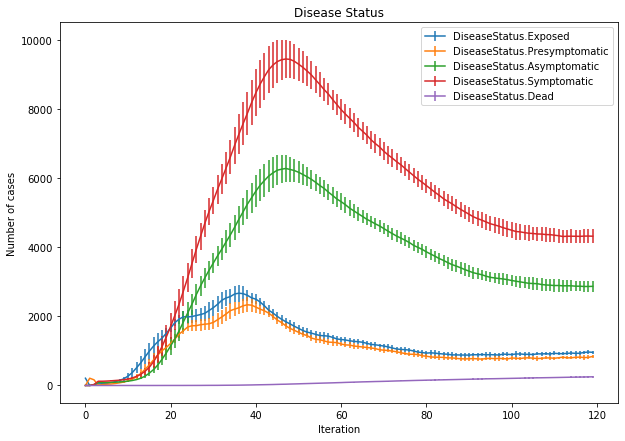

In [8]:
import matplotlib.pyplot as plt
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

def plot_summaries(summaries, iters, reps):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))

    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            for i in x:
                matrix[rep][i] = summaries[rep].total_counts[d][i]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        ax.errorbar(x, mean, sd, label=f"{disease_status}" )
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    
plot_summaries(summaries=summaries, iters=iterations, reps=repetitions)

### Disease statuses by age

In [10]:
def plot_disease_status_by_age(summary, disease_status):
    age_thresholds = summary.age_thresholds
    age_counts = summary.age_counts[disease_status]
    x = range(iterations)
    
    lower_age_bound = 0
    for (i, age_threshold) in enumerate(age_thresholds):
        plt.plot(x, age_counts[i], label=f"{lower_age_bound} - {age_threshold}")
        lower_age_bound = age_threshold
    
    plt.title(f"Num {disease_status} people by age group")
    plt.legend() 
    plt.show()
    

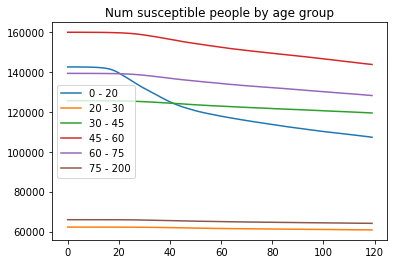

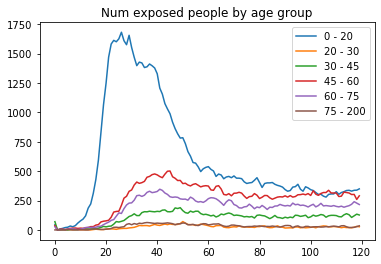

In [11]:
plot_disease_status_by_age(summaries[0], "susceptible")
plot_disease_status_by_age(summaries[0], "exposed")

### Plot MSOA geodata

#### Load MSOA shapes

In [ ]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [ ]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

In [ ]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)